Run mlserver with the following command:

mlflow server \
    --backend-store-uri sqlite:///mlruns.db \
    --default-artifact-root ./mlruns \
    --host 0.0.0.0 \
    --port 5000

then execute the notebook

In [1]:
import os
from pathlib import Path
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import mlflow

# Esto es para poder importar las funciones de src
os.chdir('/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos')

In [2]:
from datetime import datetime
import time
import mlflow

# Set MLflow tracking URI
mlflow.set_tracking_uri('http://localhost:5000')

# Create an experiment if it doesn't exist
experiment_name = f"Age Prediction Experiment {datetime.now().strftime('%Y-%m-%d_%H-%M')}"
try:
    # mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except mlflow.exceptions.MlflowException as e:
    # If the experiment already exists, you can catch the exception and continue
    print(f"Experiment '{experiment_name}' already exists.")

# Start an MLflow experiment
mlflow.start_run(run_name="Age Prediction Experiment", experiment_id="0")

start_time = time.time()



2025/02/11 13:10:34 INFO mlflow.tracking.fluent: Experiment with name 'Age Prediction Experiment 2025-02-11_13-10' does not exist. Creating a new experiment.


In [3]:
!pwd

/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos


In [4]:
dataset = Path("/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/data/processed/datasets/sentence_features/sentence_features_2025-02-11_11-59-32.csv/sentence_features_20250211_115935.csv")
df = pd.read_csv(dataset)

mlflow.log_param("initial_data_path", str(dataset))


'/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/data/processed/datasets/sentence_features/sentence_features_2025-02-11_11-59-32.csv/sentence_features_20250211_115935.csv'

In [5]:
df.head()

,file,label,f0_mean,f1_mean,f2_mean,f3_mean,intensity_mean,jitter_local,shimmer_local,f0_median,...,health-voicevow-m,health-voicevow-all,trust-voicesent-f,trust-voicesent-m,trust-voicesent-all,trust-voicevow-f,trust-voicevow-m,trust-voicevow-all,age,sex
0,M-287_VoiceSentence2(Hour).wav,M-287,124.825515,739.553045,2046.911437,3090.868964,65.461822,0.020448,0.119792,123.763596,...,"57,6","65,5","56,2","41,3","48,1","71,5","52,2","61,0",27,Male
1,F-403_VoiceSentence2(Hour).wav,F-403,216.388743,705.542279,2088.949229,3156.436895,61.776384,0.022961,0.120271,201.422374,...,"59,6","60,2","37,5","48,8","42,9","43,5","70,8","56,5",19,Female
2,M-306_VoiceSentence2(Hour).wav,M-306,102.052461,772.566397,2017.795248,3075.442214,63.196132,0.021191,0.113018,103.748156,...,"56,5","59,0","40,7","56,0","49,0","54,9","66,1","61,0",22,Male
3,M-382_VoiceSentence2(Hour).wav,M-382,135.736260,724.154933,1986.860392,3030.389802,64.510966,0.015406,0.118445,138.863157,...,"64,0","68,2","58,0","55,6","56,7","62,4","61,9","62,2",23,Male
4,F-117_VoiceSentence2(Hour).wav,F-117,209.585800,516.980513,1846.739084,2976.310072,64.746529,0.016255,0.100310,209.179233,...,"61,4","59,6","51,2","62,0","57,2","51,4","66,7","59,9",19,Female


# Feature Engineering

In [6]:
# create a new column with the aage category 10-19, 20-29, 30-39
df["age_category"] = pd.cut(df["age"], bins=[10, 19, 29, 39], labels=["10-19", "20-29", "30-39"])
df["age_category"].value_counts().sort_index()

# Map gender to 0 and 1
df.loc[:, "sex_numeric"] = df["sex"].map({"Male": 0.0, "Female": 1.0})

### Spectrogram features


In [7]:
import os
import librosa

def resize_spectrogram(spec, length, fact=-80):

    # Create an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(filename, sr=16000, hop_length=512, duration=3.0):

    # Loads the mp3 file
    y, sr = librosa.load(os.path.join("audio_dataset", filename), sr=sr)

    # Compute the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Compute mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimate the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Put mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

In [8]:
# instantiate feature extractor
from ml_project.components.preprocessing.mel_spec_feature_extractor import MelFeatureExtractor
import numpy as np


# Create arrays to store output into
spec_infos = []

# Loop through all files and extract spectrograms
sr = 16000
for f in df.file:
    f = Path("/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/data/processed/voices_sentences/2.Hour") / f
    spec_infos.append(compute_mel_spec(f, sr=sr))


# Aggregate feature types in common variable
mels = np.array([s[0] for s in spec_infos])
mels_strengths = np.array([s[1] for s in spec_infos])

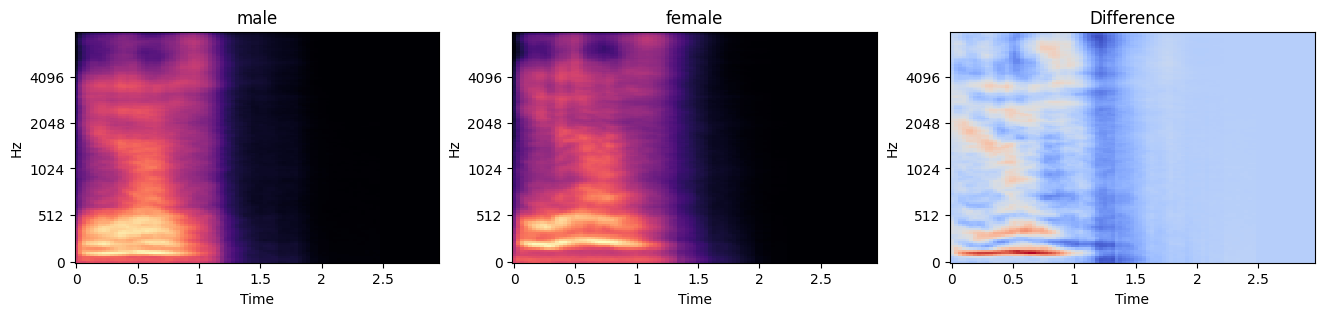

In [9]:
import librosa.display

# Creates a figure with two subplot
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Plots mel spectrogram for male speakers
mels_male = np.mean(mels[df["sex_numeric"].eq(0)], axis=0)
librosa.display.specshow(mels_male, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title("male")

# Plots mel spectrogram for female speakers
mels_female = np.mean(mels[df["sex_numeric"].eq(1)], axis=0)
librosa.display.specshow(mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("female")

# Plot gender differences
librosa.display.specshow(
    mels_male - mels_female, sr=sr, x_axis="time", y_axis="mel", ax=axs[2]
)
axs[2].set_title("Difference")
plt.show()

In [10]:
# Create age category
df.loc[:, "age_category"] = df["age_category"].map({
        "10-19": int(0),
        "20-29": int(1),
        "30-39": int(2),
})

/var/folders/sf/260b6v5x31x4l659jpkpl6dm0000gn/T/ipykernel_36411/120542149.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1, 0, 1, 1, 0, ..., 1, 1, 0, 1, 1]
Length: 108
Categories (3, int64): [0 < 1 < 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, "age_category"] = df["age_category"].map({


# Machine learning models

## Shallow ML Model

In [11]:
df.columns

Index(['file', 'label', 'f0_mean', 'f1_mean', 'f2_mean', 'f3_mean',
       'intensity_mean', 'jitter_local', 'shimmer_local', 'f0_median',
       'f0_std', 'sample_name', 'attrac-voicesent-f', 'attrac-voicesent-m',
       'attrac-voicesent-all', 'attrac-voicevow-f', 'attrac-voicevow-m',
       'attrac-voicevow-all', 'mascfem-voicesent-f', 'mascfem-voicesent-m',
       'mascfem-voicesent-all', 'mascfem-voicevow-f', 'mascfem-voicevow-m',
       'mascfem-voicevow-all', 'domin-voicesent-f', 'domin-voicesent-m',
       'domin-voicesent-all', 'domin-voicevow-f', 'domin-voicevow-m',
       'domin-voicevow-all', 'health-voicesent-f', 'health-voicesent-m',
       'health-voicesent-all', 'health-voicevow-f', 'health-voicevow-m',
       'health-voicevow-all', 'trust-voicesent-f', 'trust-voicesent-m',
       'trust-voicesent-all', 'trust-voicevow-f', 'trust-voicevow-m',
       'trust-voicevow-all', 'age', 'sex', 'age_category', 'sex_numeric'],
      dtype='object')

In [12]:
# only keep calculated columns
df_features = df[["f0_mean", "f1_mean", "f2_mean", "f3_mean", "intensity_mean", "jitter_local", "shimmer_local", "f0_median", "f0_std", "sex_numeric", "age_category"]]


In [13]:
df_features.head()

,f0_mean,f1_mean,f2_mean,f3_mean,intensity_mean,jitter_local,shimmer_local,f0_median,f0_std,sex_numeric,age_category
0,124.825515,739.553045,2046.911437,3090.868964,65.461822,0.020448,0.119792,123.763596,11.005828,0.0,1
1,216.388743,705.542279,2088.949229,3156.436895,61.776384,0.022961,0.120271,201.422374,76.876227,1.0,0
2,102.052461,772.566397,2017.795248,3075.442214,63.196132,0.021191,0.113018,103.748156,9.902460,0.0,1
3,135.736260,724.154933,1986.860392,3030.389802,64.510966,0.015406,0.118445,138.863157,25.652116,0.0,1
4,209.585800,516.980513,1846.739084,2976.310072,64.746529,0.016255,0.100310,209.179233,21.068497,1.0,0


In [14]:
# Select target
target = "age_category"
y = df_features[target].values

# Assuming 'df' is your DataFrame
df_features.columns = df_features.columns.astype(str)

# Finally, select relevant features from the dataframe
features = df_features

# Combine them with the mels strength features
X = pd.concat((features, pd.DataFrame(mels_strengths)), axis=1)

# Convert all columns data to float64
X = X.astype(np.float64)

# Convert all columns names to string, otherwise the model will not work and will throw an error
X.columns = X.columns.astype(str)

# check if all columns are float64
# X.info(verbose=True)

print(f"Amount of features: {len(X.columns)}")

Amount of features: 139


In [15]:
# Display class distribution
y.value_counts()


0    24
1    74
2    10
Name: count, dtype: int64

Target values are very imbalanced

In [16]:
from sklearn.model_selection import train_test_split

# Create train and test set
x_tr, x_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.8, shuffle=True, stratify=y, random_state=0
)

# Plot size of dataset
print(f"Train set size: {x_tr.shape}")
print(f"Test set size: {x_te.shape}")


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_tr, y_tr)

# Log the size of the train and test sets
mlflow.log_param("train_set_size", X_resampled.shape)
mlflow.log_param("test_set_size", y_resampled.shape)


Train set size: (86, 139)
Test set size: (22, 139)


(177,)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create pipeline
pipe = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("logreg", LogisticRegression(class_weight="balanced")),
    ]
)

# Assuming you have your data in a variable called X
n_samples = X.shape[0]  # Get the number of samples

# Set n_quantiles to the minimum of 1000 or the number of samples
n_quantiles = min(1000, n_samples)


# Create grid
grid = {
    "scaler": [RobustScaler(), PowerTransformer(), QuantileTransformer(n_quantiles=n_quantiles, output_distribution='uniform')],
    "pca": [None, PCA(0.99)],
    "logreg__C": np.logspace(-3, 2, num=16),
}

# Create GridSearchCV
grid_cv = GridSearchCV(pipe, grid, cv=4, return_train_score=True, verbose=1)


In [18]:
mlflow.log_param("grid_search_parameters", grid)

{'scaler': [RobustScaler(),
  PowerTransformer(),
  QuantileTransformer(n_quantiles=108)],
 'pca': [None, PCA(n_components=0.99)],
 'logreg__C': array([1.00000000e-03, 2.15443469e-03, 4.64158883e-03, 1.00000000e-02,
        2.15443469e-02, 4.64158883e-02, 1.00000000e-01, 2.15443469e-01,
        4.64158883e-01, 1.00000000e+00, 2.15443469e+00, 4.64158883e+00,
        1.00000000e+01, 2.15443469e+01, 4.64158883e+01, 1.00000000e+02])}

In [19]:
# Train GridSearchCV
model = grid_cv.fit(x_tr, y_tr)

# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (108) is greater than the total number of samples (64). n_quantiles is set to n_samples.
  warnings.warn(
/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (108) is greater than the total number of samples (64). n_quantiles is set to n_samples.
  warnings.warn(
/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (108) is greater than the total number of samples (65). n_quantiles is set to n_samples.
  warnings.warn(
/Users/antonellaschiavoni/Documents/Antonella/tesis-ciencia-de-datos/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (108) is greater than 

In [20]:
# Log cross-validation metrics
cv_results = model.cv_results_
for i in range(len(cv_results['params'])):
    with mlflow.start_run(nested=True):
        mlflow.log_params(cv_results['params'][i])
        mlflow.log_metric("mean_test_score", 
                         cv_results['mean_test_score'][i])

🏃 View run monumental-steed-155 at: http://localhost:5000/#/experiments/2/runs/7ab9fefa77784a29820ba08108964cf9
🧪 View experiment at: http://localhost:5000/#/experiments/2
🏃 View run agreeable-slug-403 at: http://localhost:5000/#/experiments/2/runs/70655cc32ead4e808345519f40bc4190
🧪 View experiment at: http://localhost:5000/#/experiments/2
🏃 View run peaceful-foal-856 at: http://localhost:5000/#/experiments/2/runs/ac0b4c386b7342c4a2299b29f1ad936a
🧪 View experiment at: http://localhost:5000/#/experiments/2
🏃 View run skittish-fly-370 at: http://localhost:5000/#/experiments/2/runs/2676f0fbf96142f3aa6a3d5f7607a7d9
🧪 View experiment at: http://localhost:5000/#/experiments/2
🏃 View run bald-rook-245 at: http://localhost:5000/#/experiments/2/runs/12a089e8a142406181993fed718ae97b
🧪 View experiment at: http://localhost:5000/#/experiments/2
🏃 View run rumbling-roo-664 at: http://localhost:5000/#/experiments/2/runs/0b3ec0104cb94889be4128b953a25949
🧪 View experiment at: http://localhost:5000/#/ex

In [21]:
from mlflow.models.signature import infer_signature

 # Infer model signature
signature = infer_signature(x_tr, model.predict(x_tr))

# Register the model
mlflow.sklearn.log_model(sk_model=model, artifact_path="model", signature=signature)

In [22]:
# Assuming 'model' is your trained model from GridSearchCV
mlflow.log_metric("best_score", model.best_score_)

# For logging the best parameters, you need to convert them into a string or log them individually
best_params = model.best_params_
for param, value in best_params.items():
    mlflow.log_param(param, value)

# If you want to log the best estimator, you might need to serialize it or log specific attributes
# For example, logging the type of the best estimator:
mlflow.log_param("best_estimator", str(model.best_estimator_))

"Pipeline(steps=[('scaler', PowerTransformer()), ('pca', PCA(n_components=0.99)),\n                ('logreg',\n                 LogisticRegression(C=np.float64(100.0),\n                                    class_weight='balanced'))])"

In [23]:
# Select the columns we are interested in
col_of_interest = [
    "param_scaler",
    "param_pca",
    "param_logreg__C",
    "mean_test_score",
    "mean_train_score",
    "std_test_score",
    "std_train_score",
]
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)
cv_results = cv_results[col_of_interest]

# Show the dataframe sorted according to our performance metric
cv_results.sort_values("mean_test_score", ascending=False)

,param_scaler,param_pca,param_logreg__C,mean_test_score,mean_train_score,std_test_score,std_train_score
94,PowerTransformer(),PCA(n_components=0.99),100.000000,0.779762,1.000000,0.088007,0.000000
76,PowerTransformer(),PCA(n_components=0.99),10.000000,0.767857,1.000000,0.072071,0.000000
82,PowerTransformer(),PCA(n_components=0.99),21.544347,0.767857,1.000000,0.072071,0.000000
91,PowerTransformer(),None,100.000000,0.755952,1.000000,0.059107,0.000000
88,PowerTransformer(),PCA(n_components=0.99),46.415888,0.755952,1.000000,0.083036,0.000000
...,...,...,...,...,...,...,...
5,QuantileTransformer(n_quantiles=108),PCA(n_components=0.99),0.001000,0.311688,0.430829,0.109719,0.158114
2,QuantileTransformer(n_quantiles=108),None,0.001000,0.311688,0.426923,0.109719,0.161152
9,RobustScaler(),PCA(n_components=0.99),0.002154,0.301407,0.523558,0.064562,0.088115
3,RobustScaler(),PCA(n_components=0.99),0.001000,0.243506,0.457572,0.046587,0.135701


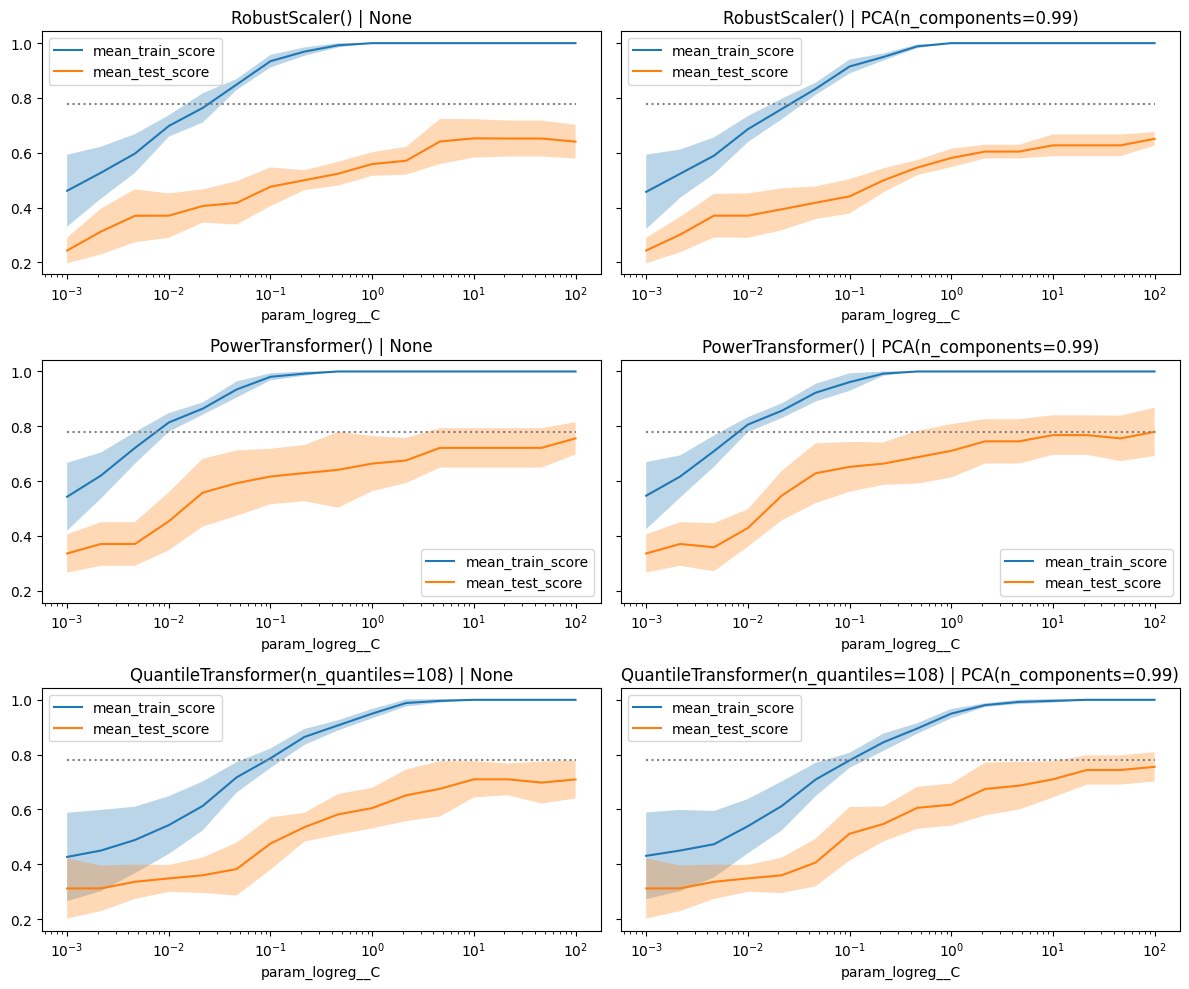

In [24]:
from itertools import product

# Establish combinations of different hyperparameters, that isn't the one
# we want to plot on the x-axis
combinations = list(product(grid["scaler"], grid["pca"]))

# Creates a figure with multiple subplot
fig, axs = plt.subplots(
    len(grid["scaler"]), len(grid["pca"]), figsize=(12, 10), sharey=True)

# Extract useful information about max performance
max_score = cv_results["mean_test_score"].max()
c_values = cv_results["param_logreg__C"]

# Loop through the subplots and populate them
for i, (s, p) in enumerate(combinations):

    # Select subplot relevant grid search results
    mask = np.logical_and(
        cv_results["param_pca"].astype("str") == str(p),
        cv_results["param_scaler"].astype("str") == str(s),
    )
    df_cv = cv_results[mask].sort_values("param_logreg__C").set_index("param_logreg__C")

    # Select relevant axis
    ax = axs.flatten()[i]

    # Plot train and test curves
    df_cv[["mean_train_score", "mean_test_score"]].plot(
        logx=True, title=f"{s} | {p}", ax=ax)
    ax.fill_between(
        df_cv.index,
        df_cv["mean_train_score"] - df_cv["std_train_score"],
        df_cv["mean_train_score"] + df_cv["std_train_score"],
        alpha=0.3,)
    ax.fill_between(
        df_cv.index,
        df_cv["mean_test_score"] - df_cv["std_test_score"],
        df_cv["mean_test_score"] + df_cv["std_test_score"],
        alpha=0.3,)

    # Plot best performance metric as dotted line
    ax.hlines(
        max_score, c_values.min(), c_values.max(), color="gray", linestyles="dotted")

# Limit y-axis
plt.tight_layout()
plt.show()

In [25]:
# Log the plot
mlflow.log_figure(fig, "grid_search_plot.png")


In [26]:
#log duration of the experiment
mlflow.log_param("duration", time.time() - start_time)

mlflow.end_run(status="FINISHED")

🏃 View run Age Prediction Experiment at: http://localhost:5000/#/experiments/0/runs/3a916205112c4cffbd792b5ee67e2ca4
🧪 View experiment at: http://localhost:5000/#/experiments/0
